In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from wordcloud import WordCloud

In [2]:
# Ensure NLTK resources are downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', force=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', force=True)

In [4]:
# Load dataset
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
    df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
except:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    df = pd.read_csv(url, compression='zip', sep='\t', names=['label', 'message'], encoding='latin-1')
df = df[['label', 'message']].dropna()
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [5]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
for i in range(len(df)):
    text = df['message'].iloc[i].lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    try:
        words = word_tokenize(text)
    except LookupError:
        nltk.download('punkt', force=True)
        words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word not in stop_words]
    df.loc[i, 'processed_text'] = ' '.join(words)

In [6]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X = tfidf.fit_transform(df['processed_text']).toarray()
y = df['label'].values

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Train and compare models
nb = MultinomialNB()
lr = LogisticRegression(max_iter=1000)
voting_clf = VotingClassifier(estimators=[('nb', nb), ('lr', lr)], voting='soft')


In [9]:
# Hyperparameter tuning
param_grid = {'nb__alpha': [0.1, 0.5, 1.0], 'lr__C': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(voting_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

In [10]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Test Accuracy: 98.21%

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[963   2]
 [ 18 132]]


In [11]:
# Save model and vectorizer
joblib.dump(final_model, 'spam_classifier.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
print("\nModel and vectorizer saved to disk!")


Model and vectorizer saved to disk!


In [12]:
# Sample predictions
print("\nSample predictions from test set:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    original_text = df.iloc[df.index[X_test.shape[0] + idx]]['message']
    actual = 'Spam' if y_test[idx] == 1 else 'Ham'
    predicted = 'Spam' if y_pred[idx] == 1 else 'Ham'
    print(f"\nMessage: {original_text[:50]}...")
    print(f"Actual: {actual}, Predicted: {predicted}")


Sample predictions from test set:

Message: SMS. ac JSco: Energy is high, but u may not know w...
Actual: Ham, Predicted: Ham

Message: Oh sorry please its over...
Actual: Ham, Predicted: Ham

Message: I think you should go the honesty road. Call the b...
Actual: Ham, Predicted: Ham

Message: Ur balance is now å£500. Ur next question is: Who ...
Actual: Ham, Predicted: Ham

Message: Wat would u like 4 ur birthday?...
Actual: Ham, Predicted: Ham


Text(158.22222222222223, 0.5, 'Actual')

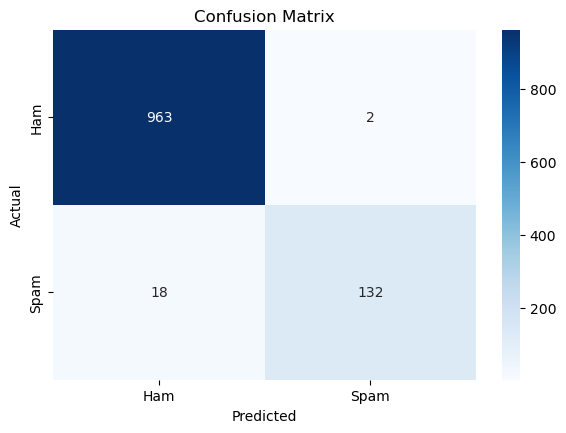

In [13]:
# Enhanced Visualizations
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(0, 0.5, 'Count')

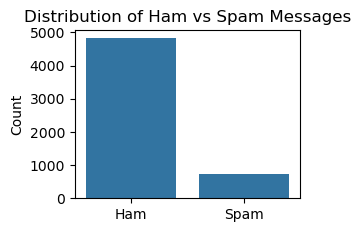

In [14]:
# 2. Class Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs Spam Messages')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.xlabel('')
plt.ylabel('Count')

Text(0.5, 1.0, 'Top 15 Important Words for Spam Detection')

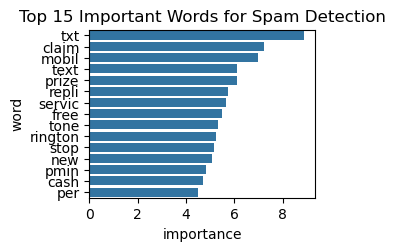

In [15]:
# 3. Top Spam Words
plt.subplot(2, 2, 3)
feature_names = tfidf.get_feature_names_out()
coefs = final_model.named_estimators_['lr'].coef_[0]
top_spam_words = pd.DataFrame({'word': feature_names, 'importance': coefs})
top_spam_words = top_spam_words.sort_values('importance', ascending=False).head(15)
sns.barplot(x='importance', y='word', data=top_spam_words)
plt.title('Top 15 Important Words for Spam Detection')

In [17]:
# 4. Word Cloud for Spam Messages
plt.subplot(2, 2, 4)
spam_words = ' '.join(df[df['label'] == 1]['processed_text'])
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Frequent Words in Spam Messages')

plt.tight_layout()
plt.savefig('spam_analysis.png')
plt.close()

In [18]:
# CLI for user input
print("\nEnter a message to classify (or 'quit' to exit):")
while True:
    user_input = input("Message: ")
    if user_input.lower() == 'quit':
        break
    text = user_input.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word not in stop_words]
    processed_text = ' '.join(words)
    vector = tfidf.transform([processed_text]).toarray()
    prediction = final_model.predict(vector)[0]
    probability = final_model.predict_proba(vector)[0][1]
    print(f"\nMessage: {user_input}")
    print(f"Prediction: {'SPAM' if prediction == 1 else 'HAM'}")
    print(f"Spam Probability: {probability:.2%}")
    feature_names = tfidf.get_feature_names_out()
    feature_values = vector[0]
    important_words = [word for word, val in zip(feature_names, feature_values) if val > 0]
    print("\nKey words in message that influenced prediction:")
    print(", ".join(important_words) if important_words else "No significant keywords found")
    if prediction == 1:
        similar_spam = df[(df['label'] == 1) & (df['processed_text'].str.contains('|'.join(important_words), regex=True))].sample(2, random_state=42) if important_words else pd.DataFrame()
        if not similar_spam.empty:
            print("\nSimilar spam messages from training data:")
            for idx, row in similar_spam.iterrows():
                print(f"- {row['message']}")


Enter a message to classify (or 'quit' to exit):

Message: you win 50 thousand pounds
Prediction: SPAM
Spam Probability: 77.82%

Key words in message that influenced prediction:
pound, thousand, win

Similar spam messages from training data:
- Win the newest åÒHarry Potter and the Order of the Phoenix (Book 5) reply HARRY, answer 5 questions - chance to be the first among readers!
- You are a winner U have been specially selected 2 receive å£1000 or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810910p/min (18+) 

Message: Oh sorry please its over...
Prediction: HAM
Spam Probability: 0.64%

Key words in message that influenced prediction:
oh, pleas, sorri

Message: 
Prediction: HAM
Spam Probability: 7.95%

Key words in message that influenced prediction:
No significant keywords found

Message: 
Prediction: HAM
Spam Probability: 7.95%

Key words in message that influenced prediction:
No significant keywords found

Message: 
Prediction: HAM
Spam Probability: 7.95%



KeyboardInterrupt: Interrupted by user